# Current Values for All States from COVID Tracking Project API

--The most recent COVID data for every state. The current value may be different than today.



In [2]:
import requests
from random import uniform 
from pprint import pprint
import pandas as pd
import numpy as np
import os
import scipy.stats as sts

from config import api_key
from census import Census
import matplotlib.pyplot as plt

# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"

covid_json = requests.get(url).json()

#PPrint the first state in list to evaluate list items
#Field description for variables can be found here : https://covidtracking.com/data/api 
pprint(covid_json[0])

{'checkTimeEt': '09/19 23:59',
 'commercialScore': 0,
 'dataQualityGrade': 'A',
 'date': 20200920,
 'dateChecked': '2020-09-20T03:59:00Z',
 'dateModified': '2020-09-20T03:59:00Z',
 'death': 45,
 'deathConfirmed': 45,
 'deathIncrease': 0,
 'deathProbable': None,
 'fips': '02',
 'grade': '',
 'hash': 'd939ccbfc0a45044ede4b81384f1a41520b50f87',
 'hospitalized': None,
 'hospitalizedCumulative': None,
 'hospitalizedCurrently': 43,
 'hospitalizedIncrease': 0,
 'inIcuCumulative': None,
 'inIcuCurrently': None,
 'lastUpdateEt': '9/20/2020 03:59',
 'negative': 419158,
 'negativeIncrease': 3982,
 'negativeRegularScore': 0,
 'negativeScore': 0,
 'negativeTestsAntibody': None,
 'negativeTestsPeopleAntibody': None,
 'negativeTestsViral': 419584,
 'onVentilatorCumulative': None,
 'onVentilatorCurrently': 13,
 'pending': None,
 'posNeg': 426925,
 'positive': 7767,
 'positiveCasesViral': 7767,
 'positiveIncrease': 93,
 'positiveScore': 0,
 'positiveTestsAntibody': None,
 'positiveTestsAntigen': None,


In [3]:
states= []
deaths= []
hospitalized = []
covid_positives = []
dates = []
fips_list=[]

indices = list( range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips_list.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    hospitalized.append(covid_json[i]['hospitalizedCumulative'])
    covid_positives.append(covid_json[i]['positive'])
    

    



In [4]:
AllStates_dict = {
    "States": states,
    "FIPS": fips_list,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Cumaltive Hospitalized": hospitalized,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict)
AllStates_df.head()

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths
0,AK,02,20200920,7767,NaN,45
1,AL,01,20200920,144962,16227.0,2437
2,AR,05,20200920,75723,4967.0,1181
3,AS,60,20200920,0,NaN,0
4,AZ,04,20200920,214018,21876.0,5476


In [5]:
# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)
table_id = 'B01003'   

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]
census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'state:*'})

for i in range(len(table_info)) : 
    for d in census_data:
        d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_TotalPop_df = pd.DataFrame(census_data)

Number of available variables: 4


In [6]:
AllStates_df['State Pop']= ""
AllStates_df['Covid Positive Per 100,000']= ""
AllStates_df['Covid Deaths Per 100,000']= ""
AllStates_df

AllState_combined_df = pd.merge(AllStates_df, census_TotalPop_df, how='left', left_on = 'FIPS', right_on = 'state')
AllState_combined_df['State Pop'] = AllState_combined_df['Estimate!!Total']
AllState_combined_df['Covid Positive Per 100,000'] = (AllState_combined_df['Covid Positive'] / AllState_combined_df['State Pop'])*100000 
AllState_combined_df['Covid Deaths Per 100,000'] = (AllState_combined_df['Deaths'] / AllState_combined_df['State Pop'])*100000 
AllState_combined_dropC = AllState_combined_df.drop(columns=['Cumaltive Hospitalized', 'state','Estimate!!Total'])

#drop rows
AllState_combined_clean = AllState_combined_dropC.dropna(axis=0, how='any')

file_path = os.path.join("Input","Per Capita Personal Health Care.csv") 
percapita_data = pd.read_csv(file_path)


AllState_with_costs = pd.merge(AllState_combined_clean , percapita_data, how='left', on = 'States')
AllState_with_costs = AllState_with_costs.dropna(axis=0, how='any')

AllState_with_costs= AllState_with_costs.rename(columns = {"TAP Per Capita State Est Personal Health Care (Dollars)": "Healthcare Costs Per Capita"})
AllState_with_costs.head()

,States,FIPS,Date,Covid Positive,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000",NAME,Healthcare Costs Per Capita
0,AK,02,20200920,7767,45,738516.0,1051.703687,6.093301,Alaska,11064.0
1,AL,01,20200920,144962,2437,4864680.0,2979.887680,50.095793,Alabama,7281.0
2,AR,05,20200920,75723,1181,2990671.0,2531.973594,39.489466,Arkansas,7408.0
3,AZ,04,20200920,214018,5476,6946685.0,3080.865190,78.828967,Arizona,6452.0
4,CA,06,20200920,778400,14987,39148760.0,1988.313295,38.282183,California,7549.0


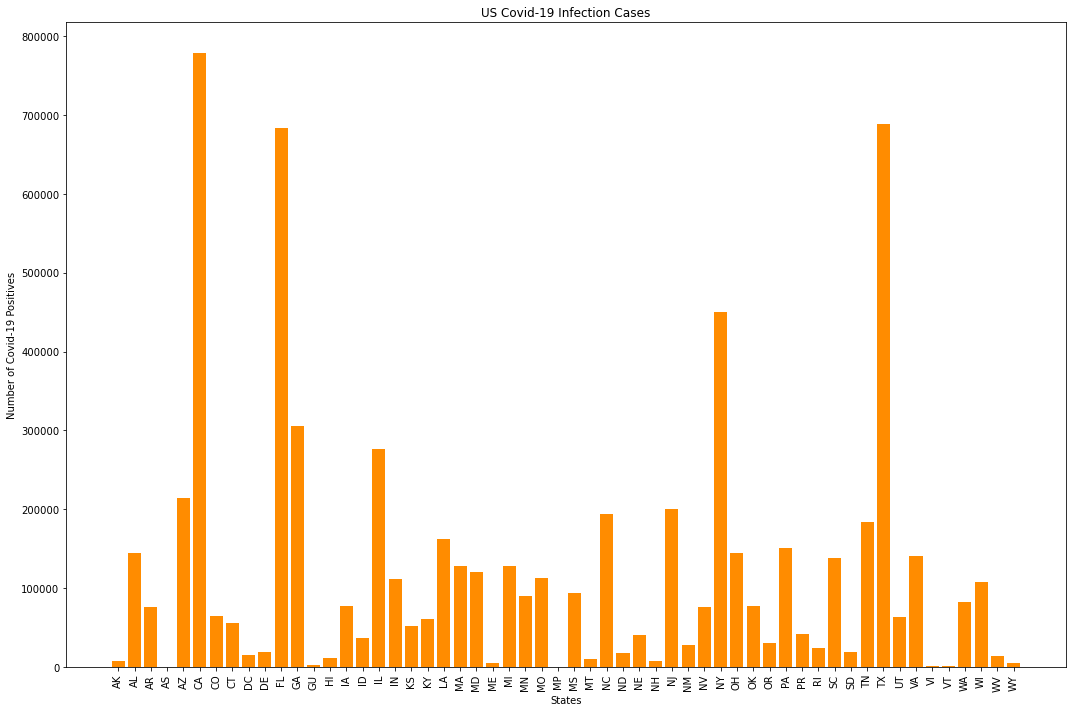

In [7]:

# import matplotlib.pyplot as plt

x_axis = np.arange(len(AllStates_df))

plt.figure(figsize=(15,10))
plt.bar(x_axis, AllStates_df["Covid Positive"], color='darkorange')
plt.title("US Covid-19 Infection Cases")
plt.xlabel("States")
plt.ylabel("Number of Covid-19 Positives")
x = plt.xticks(x_axis, AllStates_df["States"], rotation="vertical")

plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_State_Infections.png')
plt.savefig(outfile)

# Are there states that are outliers for COVID19 Infections?

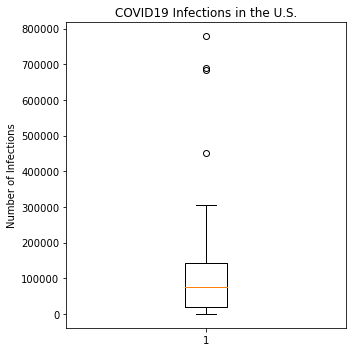

In [8]:
covid19_infxn = AllStates_df['Covid Positive']

plt.figure(figsize=(5,5))
plt.title('COVID19 Infections in the U.S.')
plt.ylabel('Number of Infections')
plt.boxplot(covid19_infxn)
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Infections_Boxplot.png')
plt.savefig(outfile)

plt.show()




In [9]:
quantiles = covid19_infxn.quantile([.25,.5,.75])
quantiles

0.25     18511.5
0.50     75763.5
0.75    141460.5
Name: Covid Positive, dtype: float64

In [10]:
Q1 = quantiles[0.25]
Q3 = quantiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Infections is: {Q1}")
print(f"The upper quartile of COVID19 Infections is: {Q3}")
print(f"The interquartile range of COVID19 Infections is: {iqr}")
print(f"The the median of COVID19 Infections is: {quantiles[0.5]} ")


The lower quartile of COVID19 Infections is: 18511.5
The upper quartile of COVID19 Infections is: 141460.5
The interquartile range of COVID19 Infections is: 122949.0
The the median of COVID19 Infections is: 75763.5 


In [11]:
lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

Values below -165912.0 could be outliers.
Values above 325884.0 could be outliers.


In [12]:
outliers = AllStates_df.loc[(AllStates_df['Covid Positive'] < lower_bound) | (AllStates_df['Covid Positive'] > upper_bound)]
outliers

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000"
5,CA,06,20200920,778400,NaN,14987,,,
10,FL,12,20200920,683754,42939.0,13459,,,
37,NY,36,20200920,449900,89995.0,25427,,,
47,TX,48,20200920,688534,NaN,14893,,,


In [13]:
print("These states are outliers in USA for COVID19 Infections:")
print(outliers['States'])

These states are outliers in USA for COVID19 Infections:
5     CA
10    FL
37    NY
47    TX
Name: States, dtype: object


# Are there states that are outliers for COVID19 deaths?

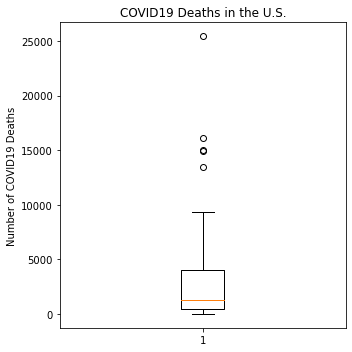

In [14]:

covid_deaths = AllStates_df['Deaths']


plt.figure(figsize=(5,5))
plt.title('COVID19 Deaths in the U.S.')
plt.ylabel('Number of COVID19 Deaths')
plt.boxplot(covid_deaths)
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Deaths_Boxplot.png')
plt.savefig(outfile)


plt.show()

In [15]:
quartiles = covid_deaths.quantile([.25,.5,.75])
quartiles

0.25     439.50
0.50    1257.50
0.75    4032.25
Name: Deaths, dtype: float64

In [16]:
Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Deaths is: {Q1}")
print(f"The upper quartile of COVID19 Deaths is: {Q3}")
print(f"The interquartile range of COVID19 Deaths is: {iqr}")
print(f"The the median of COVID19 Deaths is: {quartiles[0.5]} ")


The lower quartile of COVID19 Deaths is: 439.5
The upper quartile of COVID19 Deaths is: 4032.25
The interquartile range of COVID19 Deaths is: 3592.75
The the median of COVID19 Deaths is: 1257.5 


In [17]:
lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

Values below -4949.625 could be outliers.
Values above 9421.375 could be outliers.


In [18]:
outliers = AllStates_df.loc[(AllStates_df['Deaths'] < lower_bound) | (AllStates_df['Deaths'] > upper_bound)]
outliers

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000"
5,CA,06,20200920,778400,NaN,14987,,,
10,FL,12,20200920,683754,42939.0,13459,,,
34,NJ,34,20200920,199762,23130.0,16067,,,
37,NY,36,20200920,449900,89995.0,25427,,,
47,TX,48,20200920,688534,NaN,14893,,,


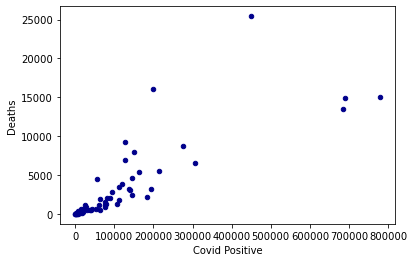

In [19]:
import scipy.stats as sts

AllStates_df.plot.scatter(x='Covid Positive',
                      y='Deaths',
                      c='DarkBlue')

In [20]:



correlation = sts.pearsonr(covid19_infxn, covid_deaths)

print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

The correlation coefficient (r) is 0.82
The p-value is 1.1346914678892113e-14


In [21]:
from scipy.stats import linregress
from sklearn import datasets



# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(covid19_infxn, covid_deaths)

# Calculate the predictions for each value of x (# Rooms)
regression_values = covid19_infxn * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


The r-squared is: 0.6717240628985709


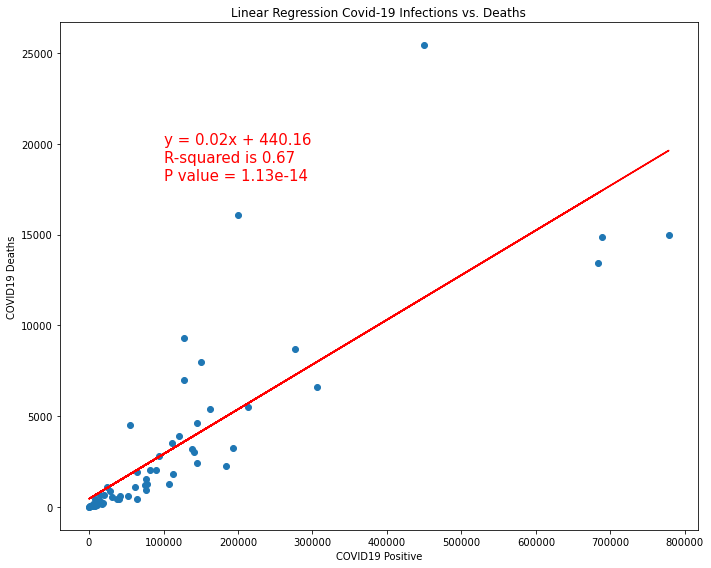

In [22]:
pvalue_str = "P value = 1.13e-14"

r2 = "R-squared is 0.67"


plt.figure(figsize=(10,8))
# Plot observations
plt.scatter(covid19_infxn, covid_deaths)

# Plot the regression line
plt.plot(covid19_infxn, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (100000, 20000), fontsize=15, color="red")
plt.annotate(r2, (100000, 19000), fontsize=15, color="red")
plt.annotate(pvalue_str, (100000, 18000), fontsize=15, color="red")
plt.xlabel('COVID19 Positive')
plt.ylabel('COVID19 Deaths')
plt.title('Linear Regression Covid-19 Infections vs. Deaths')
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_State_Infections_Deaths_LR.png')
plt.savefig(outfile)


print(f"The r-squared is: {rvalue**2}")
plt.show()

# COVID19 Infections Per Capita

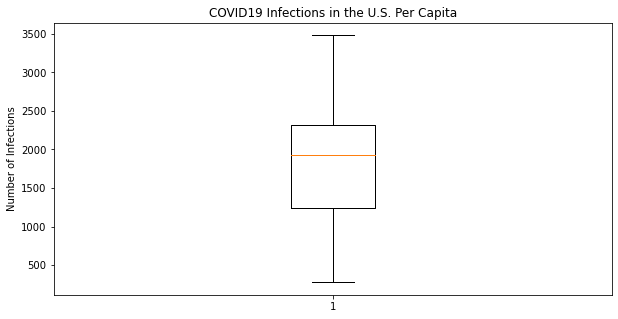

In [23]:
covid19_infxn_capita = AllState_combined_clean['Covid Positive Per 100,000']

plt.figure(figsize=(10,5))
plt.title('COVID19 Infections in the U.S. Per Capita')
plt.ylabel('Number of Infections')
plt.boxplot(covid19_infxn_capita)
plt.show()


In [24]:
quartiles = covid19_infxn_capita.quantile([.25,.5,.75])

Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Infections per 100,000 is: {Q1}")
print(f"The upper quartile of COVID19 Infections per 100,000 is: {Q3}")
print(f"The interquartile range of COVID19 Infections per 100,000 is: {iqr}")
print(f"The the median of COVID19 Infections per 100,000 is: {quartiles[0.5]} ")

lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outliers = AllState_combined_clean.loc[(AllState_combined_clean['Covid Positive Per 100,000'] < lower_bound) | (AllState_combined_clean['Covid Positive Per 100,000'] > upper_bound)]
outliers

The lower quartile of COVID19 Infections per 100,000 is: 1238.4944453718117
The upper quartile of COVID19 Infections per 100,000 is: 2316.7852857700736
The interquartile range of COVID19 Infections per 100,000 is: 1078.290840398262
The the median of COVID19 Infections per 100,000 is: 1933.2198406111243 
Values below -378.9418152255812 could be outliers.
Values above 3934.2215463674665 could be outliers.


,States,FIPS,Date,Covid Positive,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000",NAME


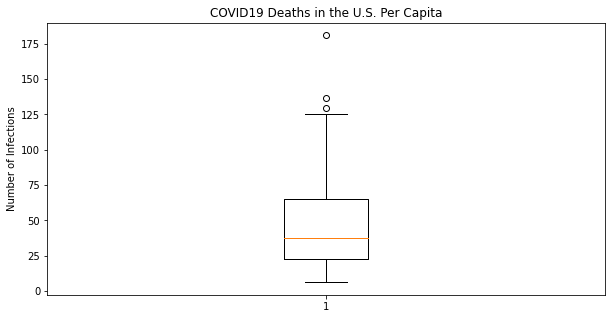

In [25]:
covid19_deaths_capita = AllState_combined_clean['Covid Deaths Per 100,000']

plt.figure(figsize=(10,5))
plt.title('COVID19 Deaths in the U.S. Per Capita')
plt.ylabel('Number of Infections')
plt.boxplot(covid19_deaths_capita)
plt.show()


In [26]:
quartiles = covid19_deaths_capita.quantile([.25,.5,.75])

Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
iqr = Q3 - Q1

print(f"The lower quartile of COVID19 Deaths per 100,000 is: {Q1}")
print(f"The upper quartile of COVID19 Deaths per 100,000 is: {Q3}")
print(f"The interquartile range of COVID19 Deaths per 100,000 is: {iqr}")
print(f"The the median of COVID19 Deaths per 100,000 is: {quartiles[0.5]} ")

lower_bound = Q1 - (1.5*iqr)
upper_bound = Q3 + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outliers = AllState_combined_clean.loc[(AllState_combined_clean['Covid Deaths Per 100,000'] < lower_bound) | (AllState_combined_clean['Covid Deaths Per 100,000'] > upper_bound)]
outliers

The lower quartile of COVID19 Deaths per 100,000 is: 22.811844457703153
The upper quartile of COVID19 Deaths per 100,000 is: 64.79497037333914
The interquartile range of COVID19 Deaths per 100,000 is: 41.98312591563599
The the median of COVID19 Deaths per 100,000 is: 37.38669824109175 
Values below -40.16284441575083 could be outliers.
Values above 127.76965924679313 could be outliers.


,States,FIPS,Date,Covid Positive,Deaths,State Pop,"Covid Positive Per 100,000","Covid Deaths Per 100,000",NAME
21,MA,25,20200920,127540,9310,6830193.0,1867.297161,136.306544,Massachusetts
34,NJ,34,20200920,199762,16067,8881845.0,2249.104775,180.897100,New Jersey
37,NY,36,20200920,449900,25427,19618453.0,2293.249116,129.607569,New York


The correlation coefficient (r) is 0.47
The p-value is 0.00041754883452676546
The r-squared is: 0.22235810533952885


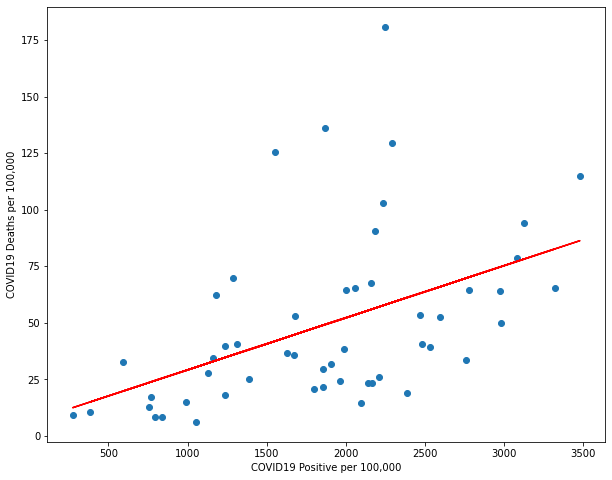

In [27]:
correlation = sts.pearsonr(covid19_infxn_capita, covid19_deaths_capita)

print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")


# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(covid19_infxn_capita, covid19_deaths_capita)

# Calculate the predictions for each value of x (# Rooms)
regression_values = covid19_infxn_capita * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,8))
# Plot observations
plt.scatter(covid19_infxn_capita, covid19_deaths_capita)

# Plot the regression line
plt.plot(covid19_infxn_capita, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (.010, .001), fontsize=15, color="red")
plt.xlabel('COVID19 Positive per 100,000')
plt.ylabel('COVID19 Deaths per 100,000')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [28]:
AllState_with_costs['Healthcare Costs Per Capita']

0     11064.0
1      7281.0
2      7408.0
3      6452.0
4      7549.0
5      6804.0
6      9859.0
8     10254.0
9      8076.0
10     6587.0
11     7299.0
12     8200.0
13     6927.0
14     8262.0
15     8300.0
16     7651.0
17     8004.0
18     7815.0
19    10559.0
20     8602.0
21     9531.0
22     8055.0
23     8871.0
24     8107.0
25     7646.0
26     8221.0
27     7264.0
28     9851.0
29     8412.0
30     9589.0
31     8859.0
32     7214.0
33     6714.0
34     9778.0
35     8712.0
36     7627.0
37     8044.0
38     9258.0
40     9551.0
41     7311.0
42     8933.0
43     7372.0
44     6998.0
45     5982.0
46     7556.0
47    10190.0
48     7913.0
49     8702.0
50     9462.0
51     8320.0
Name: Healthcare Costs Per Capita, dtype: float64

# Correlation of Infections vs. Healthcare costs

The correlation coefficient (r) is -0.4
The p-value is 0.004283566209229198


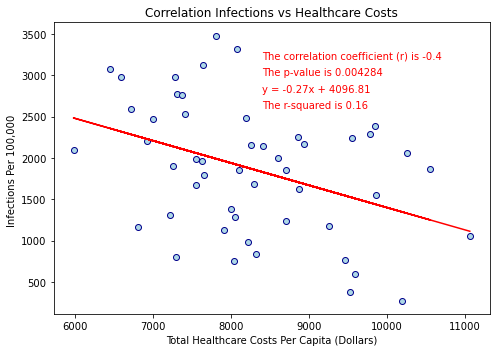

In [29]:
plt.figure(figsize=(7,5))
plt.scatter(x=AllState_with_costs['Healthcare Costs Per Capita'], y=AllState_with_costs['Covid Positive Per 100,000'], marker="o", facecolors="lightblue", edgecolors="darkblue")
plt.ylabel("Infections Per 100,000 ")
plt.xlabel("Total Healthcare Costs Per Capita (Dollars)")
plt.title("Correlation Infections vs Healthcare Costs")
correlation = sts.pearsonr(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Positive Per 100,000'])
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Positive Per 100,000'])
# Calculate the predictions for each value of x (# Rooms)
regression_values = AllState_with_costs['Healthcare Costs Per Capita'] * slope + intercept
# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(AllState_with_costs['Healthcare Costs Per Capita'], regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(f"The correlation coefficient (r) is {round(correlation[0],2)}", (8400, 3200), fontsize=10, color="red")
plt.annotate(f"The p-value is {round(correlation[1], 6)}", (8400, 3000), fontsize=10, color="red")
plt.annotate(line_eq, (8400, 2800), fontsize=10, color="red")
plt.annotate(f"The r-squared is {round(rvalue**2, 2)}", (8400, 2600), fontsize=10, color="red" )

plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_InfectionsVHealthcareCosts.png')
plt.savefig(outfile)

plt.show()


# Correlation of Mortality vs. Healthcare costs

The correlation coefficient (r) is 0.17
The p-value is 0.2376924442345409


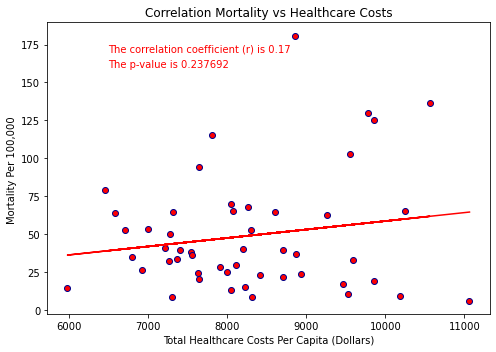

In [30]:

plt.figure(figsize=(7,5))
plt.scatter(x=AllState_with_costs['Healthcare Costs Per Capita'], y=AllState_with_costs['Covid Deaths Per 100,000'], marker="o", facecolors="red", edgecolors="darkblue")
plt.ylabel("Mortality Per 100,000 ")
plt.xlabel("Total Healthcare Costs Per Capita (Dollars)")
plt.title("Correlation Mortality vs Healthcare Costs")

correlation = sts.pearsonr(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Deaths Per 100,000'])
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")


# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(AllState_with_costs['Healthcare Costs Per Capita'],AllState_with_costs['Covid Deaths Per 100,000'])
# Calculate the predictions for each value of x (# Rooms)
regression_values = AllState_with_costs['Healthcare Costs Per Capita'] * slope + intercept
# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# Plot the regression line
plt.plot(AllState_with_costs['Healthcare Costs Per Capita'], regression_values, "red")
# Annotate the plot with the linear equation
plt.annotate(f"The correlation coefficient (r) is {round(correlation[0],2)}", (6500, 170), fontsize=10, color="red")
plt.annotate(f"The p-value is {round(correlation[1], 6)}", (6500, 160), fontsize=10, color="red")


plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_MortalityVHealthcareCosts.png')
plt.savefig(outfile)



plt.show()

In [31]:
state_comparison = AllState_with_costs[['States', 'Covid Positive', 'Healthcare Costs Per Capita']]
state_comparison.head()


,States,Covid Positive,Healthcare Costs Per Capita
0,AK,7767,11064.0
1,AL,144962,7281.0
2,AR,75723,7408.0
3,AZ,214018,6452.0
4,CA,778400,7549.0


In [32]:
state_comparison = state_comparison.sort_values(by=['Healthcare Costs Per Capita'])
state_comparison.head()


,States,Covid Positive,Healthcare Costs Per Capita
45,UT,63772,5982.0
3,AZ,214018,6452.0
10,GA,306155,6587.0
33,NV,75804,6714.0
5,CO,64356,6804.0


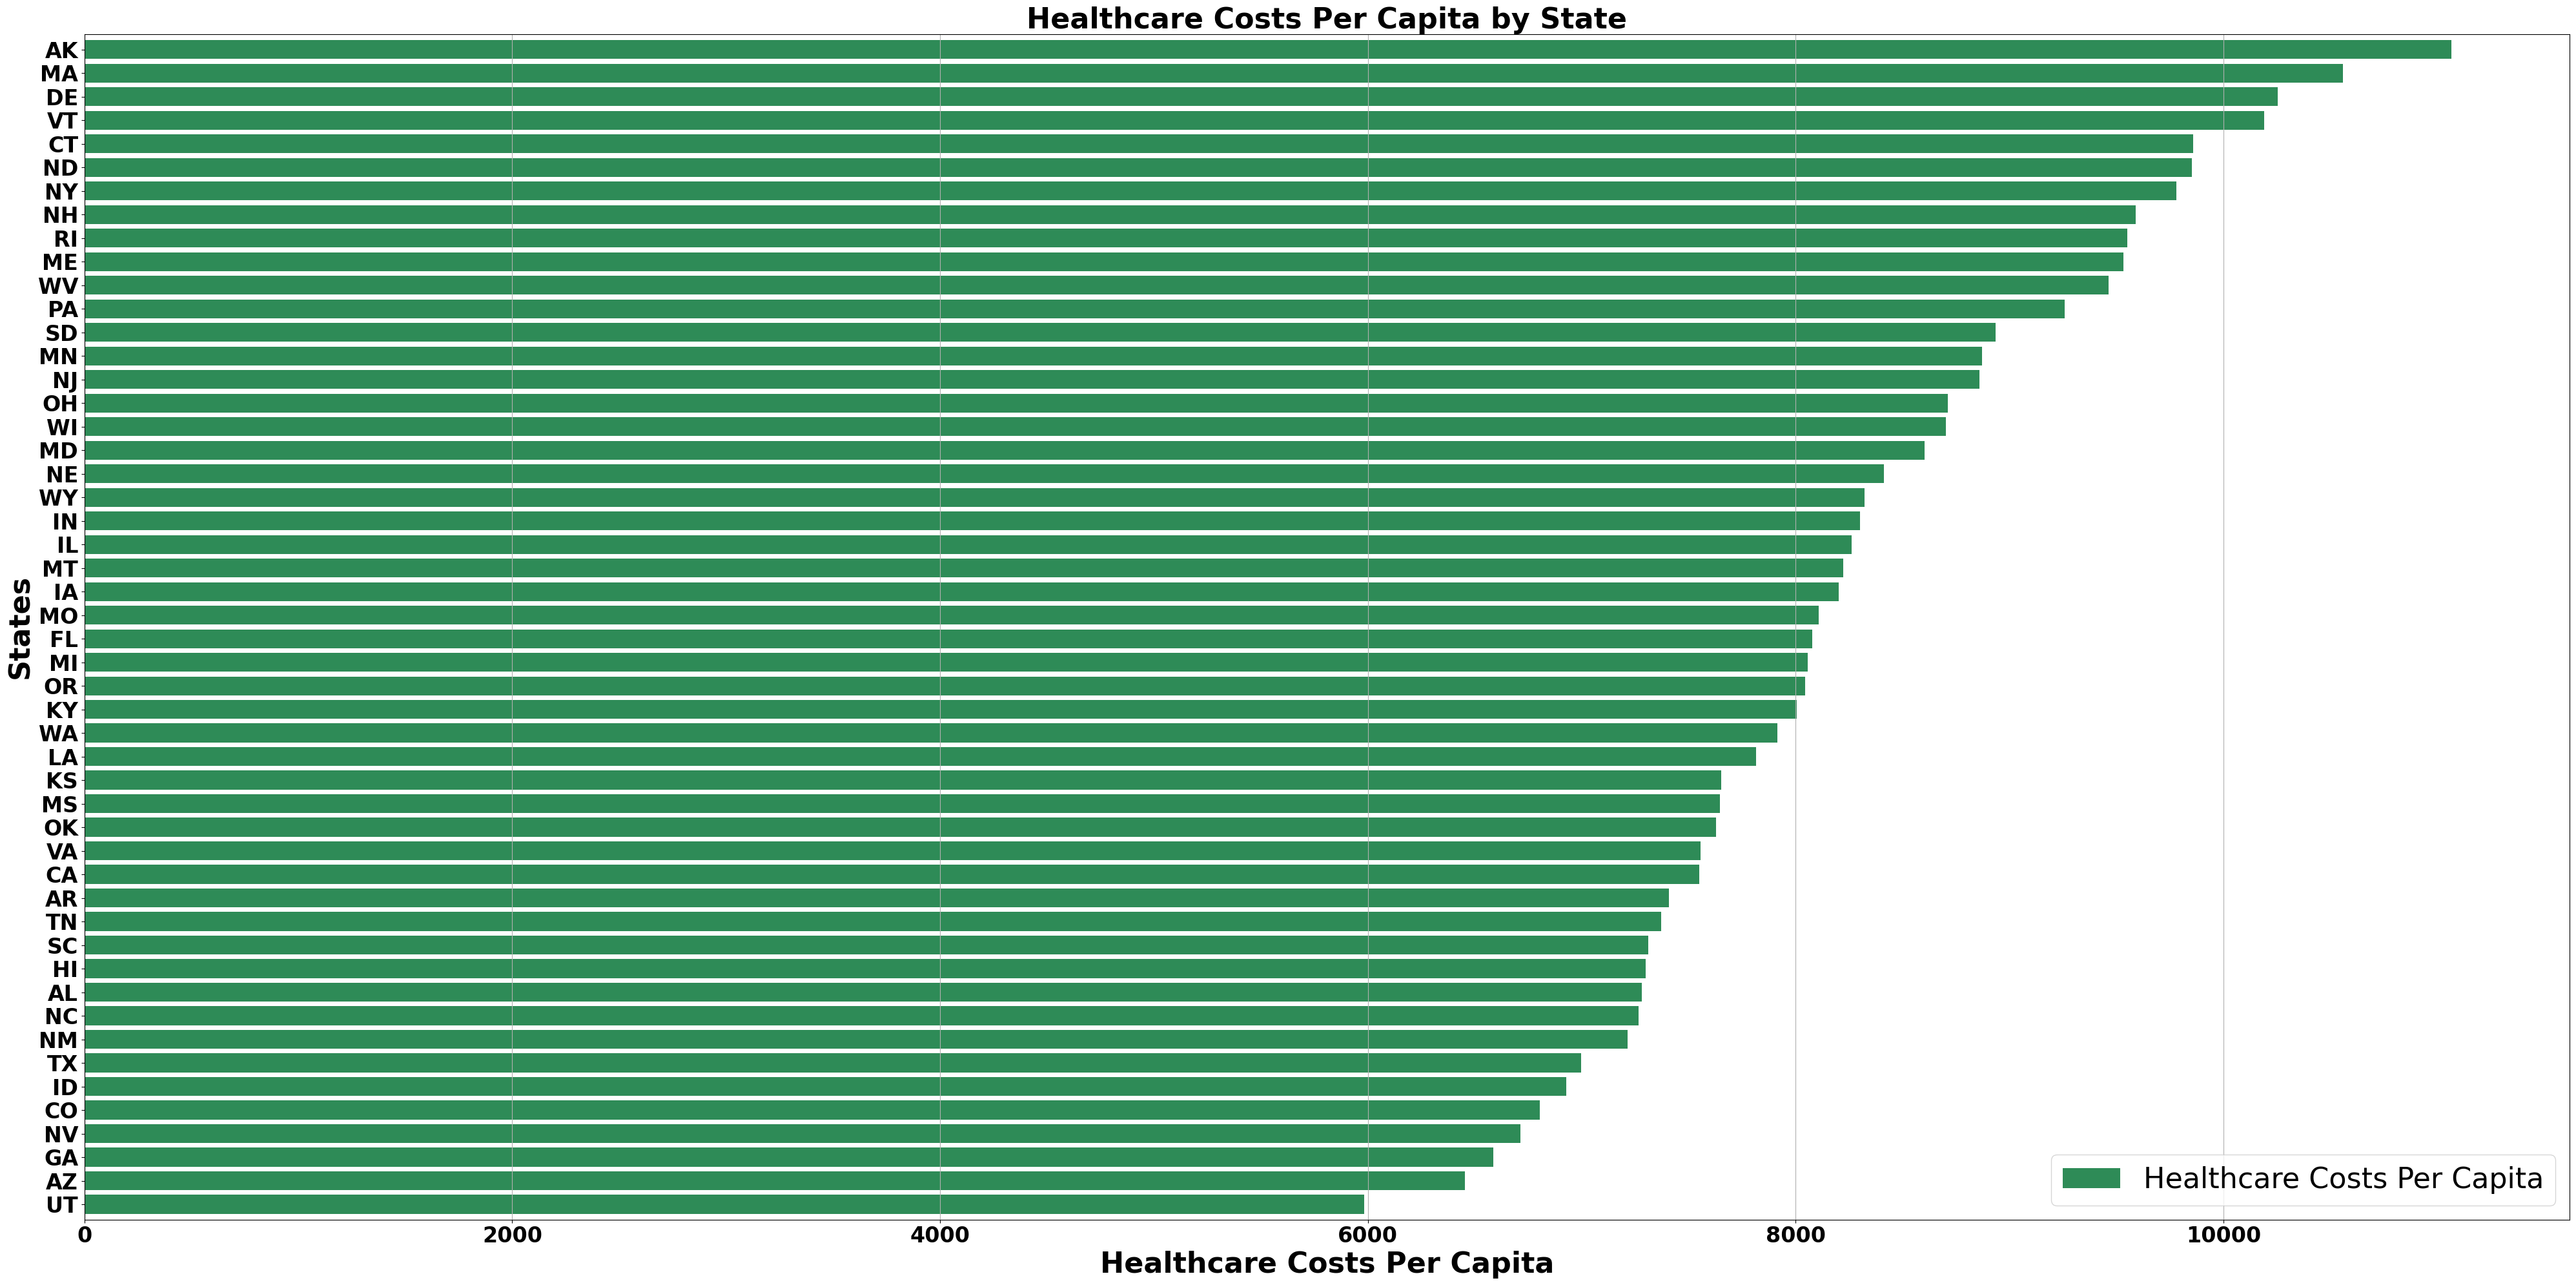

In [61]:
state_comparison  = state_comparison.reset_index(drop=True)

state_comparison.plot(kind='barh', y = 'Healthcare Costs Per Capita' , 
                                 figsize=(40,20), color='seagreen',width=0.8, stacked=True)
y_axis = state_comparison.index 

plt.style.use('default')
plt.yticks(y_axis, state_comparison['States'], fontsize=24, weight = 'bold')
plt.xticks(fontsize=24,weight = 'bold')
plt.grid(b=None, which='major', axis='x')
plt.title("Healthcare Costs Per Capita by State", fontsize=32, weight = 'bold')
plt.xlabel("Healthcare Costs Per Capita", fontsize=32, weight = 'bold')
plt.ylabel("States", fontsize=32, weight = 'bold')
plt.legend(prop={'size': 32})
plt.tight_layout()

outfile = os.path.join("Output", "Healthcare_Costs_Capita_States.png")
plt.savefig(outfile)

